In [ ]:
# !pip install catboost
# !pip install shap

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn import preprocessing
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

import shap

In [191]:
def get_dif(largest_iso, least_iso):
  for col in ['bus_stop', 'house', 'kiosk',
        'retail', 'station', 'subway_entrance', 'tram_stop', 'bar', 'cafe',
        'fast_food', 'food_court', 'pub', 'restaurant', 'college',
        'driving_school', 'language_school', 'school', 'kindergarten',
        'university', 'car_wash', 'fuel', 'atm', 'bank', 'clinic', 'dentist',
        'doctors', 'hospital', 'pharmacy', 'veterinary', 'theatre', 'cinema',
        'hostel', 'hotel', 'office', 'shop']:
    largest_iso[col] = largest_iso[col]-least_iso[col]

In [192]:
df_target = pd.read_csv('data/vkusvill_target.csv')
data = pd.read_csv('data/vkusvill_data_without_target.csv')
iso_30 = pd.read_csv('data/vkusvill_isochrone_30.csv')
iso_25 = pd.read_csv('data/vkusvill_isochrone_25.csv')
iso_20 = pd.read_csv('data/vkusvill_isochrone_20.csv')
iso_15 = pd.read_csv('data/vkusvill_isochrone_15.csv')
iso_10 = pd.read_csv('data/vkusvill_isochrone_10.csv')
dist_df = pd.read_csv('data/vkusvill_dist.csv')

get_dif(iso_30, iso_25)
get_dif(iso_25, iso_20)
get_dif(iso_20, iso_15)
get_dif(iso_15, iso_10)

revenue = df_target['Выручка р/мес'].values
avg_check = df_target["Выручка р/мес"] / df_target["Чеки шт/мес"]
num_checks = df_target["Чеки шт/мес"].values

In [193]:
work_schedule = [
    ['с 9-00 до 22-00', 9, 22, 9, 22, 0], 
    ['с 8-00 до 22-00', 8, 22, 8, 22, 0],
    ['пн-чт с 7-00 - 23-45, пт-сб с 8-00 - 23-00, вс с 7-00 - 23-45', 7, 23, 7, 23, 1],
    ['Откл. с 9:00 до 22:00', 9, 22, 9, 22, 0], 
    ['с 7-00 до 22-00', 7, 22, 7, 22, 0],
    ['будни с 8-00 до 22-00; вых. с 9-00 до 22-00', 8, 22, 9, 22, 1], 
    ['с 10-00 до 22-00', 10, 22, 10, 22, 0],
    ['будни с 9-00 до 23-00, выходные с 9-00 до 22-00', 9, 23, 9, 22, 1],
    ['с 9-00 до 21-00', 9, 21, 9, 21, 0], 
    ['Будни с 8 до 23, вых с 8 до 22', 8, 23, 8, 22, 1],
    ['с 7:00 до 23:45', 7, 23, 7, 23, 0], 
    ['Откл. с 11:00 до 21:00', 11, 21, 11, 21, 0],
    ['Откл. с 8:00 до 22:00', 8, 22, 8, 22, 0], 
    ['с 8-00 до 23-45', 8, 23, 8, 23, 0], 
    ['с 8-00 до 23-00', 8, 23, 8, 23, 0],
    ['Будни с8:00 до 23:00 вых с 8:00 до 22:00', 8, 23, 8, 22, 1],
    ['будни с 8-00 до 23-00, вых. 9-00 до 23-00', 8, 23, 9, 23, 1],
    ['пн-пт с 8-00 до 23-00, сб-вс с 9-00 до 22-00', 8, 23, 9, 22, 1],
    ['вс-чт. с 10:00 до 23:00, пт-сб. с 10:00 по 24:00', 10, 23, 10, 24, 1],
    ['пн-чт с 7-00 - 23-45, пт-сб с 7-00 - 23-00, вс с 7-00 - 23-45', 7, 23, 7, 23, 1],
    ['с 8-30 до 23-00', 8, 23, 8, 23, 0], 
    ['с 7-00 до 23-45', 7, 23, 7, 23, 0],
    ['пн-чт с 7-00 - 23-45, пт-сб с 7-00 - 22-00, вс с 8-00 - 23-45', 7, 23, 8, 23, 1],
    ['с пн по чт с 7 до 23:45, пт с 7 до 23:00, сб с 8 до 22:00, вс 8 до 23:45', 7, 23, 8, 23, 1],
    ['бд 7-00 до23-00 вх 8-00 до 22-00', 7, 23, 8, 22, 1], 
    ['с 9:00 до 23:00', 9, 23, 9, 23, 0],
    ['с 7-00 до 23-00', 7, 23, 7, 23, 0]
]

work_schedule = pd.DataFrame(
    work_schedule, 
    columns=["График", "Будни начало", "Будни конец", "Выходные начало", "Выходные конец", "Разные графики"]
    )

data = pd.merge(data, work_schedule, on="График", how="left")
data['Рабочие часы в будни'] = data['Будни конец'] - data['Будни начало']
data['Рабочие часы в выходные'] = data['Выходные конец'] - data['Выходные начало']
data['Ночной магазин'].replace({'Нет': 0, 'Да': 1}, inplace=True)

In [194]:
data = pd.concat([data, pd.get_dummies(data['Город'])], axis=1)

In [195]:
data = pd.concat([data, dist_df[['dist_to_city_center', 'time_to_city_center_car_m', 'p_huff']]], axis=1) 

In [196]:
def add_iso(new_features, iso):
  new_features_aggregated = pd.DataFrame(columns=['medicine'+iso, 
                                                   'stations'+iso, 'housing'+iso,
                                                   'shops'+iso, 'atms+banks'+iso,
                                                   'office'+iso,
                                                  'food'+iso,'for_motorists'+iso,
                                                  # 'house'+iso,
                                                  # 'education'+iso,'kindergarten'+iso,'entertainment'+iso,
                                                  ])

  new_features_aggregated['medicine'+iso] = new_features['clinic']+new_features['dentist']+\
                                        new_features['doctors']+new_features['hospital']+\
                                        new_features['pharmacy']

  new_features_aggregated['food'+iso] = new_features['food_court']+new_features['pub']+\
                                    new_features['restaurant']+new_features['cafe']+\
                                    new_features['bar']+new_features['fast_food']

  # new_features_aggregated['education'+iso] = new_features['college']+new_features['driving_school']+\
  #                                       new_features['language_school']+new_features['school']+\
  #                                       new_features['university']
                                    
  new_features_aggregated['stations'+iso] = new_features['bus_stop']+new_features['station']+\
                                        new_features['subway_entrance']+new_features['tram_stop']     

  new_features_aggregated['housing'+iso] = new_features['hotel']+new_features['hostel']

  new_features_aggregated['for_motorists'+iso] = new_features['car_wash']+new_features['fuel']

  new_features_aggregated['shops'+iso] = new_features['kiosk']+new_features['retail']+new_features['shop']

  new_features_aggregated['atms+banks'+iso] = new_features['atm']+new_features['bank']

  # new_features_aggregated['entertainment'+iso] = new_features['theatre']+new_features['cinema']

  # new_features_aggregated['house'+iso] = new_features['house']
  # new_features_aggregated['kindergarten'+iso] = new_features['kindergarten']
  new_features_aggregated['office'+iso] = new_features['office']

  return new_features_aggregated

In [197]:
data = pd.concat([data, add_iso(iso_10, '10')], axis=1) 
data = pd.concat([data, add_iso(iso_15, '15')], axis=1) 
data = pd.concat([data, add_iso(iso_20, '20')], axis=1) 
data = pd.concat([data, add_iso(iso_25, '25')], axis=1)
data = pd.concat([data, add_iso(iso_30, '30')], axis=1)  

In [198]:
# df = pd.read_csv('data/vkusvill_shop_v2.csv')
# new_df = pd.DataFrame()
# new_df['Номерточки'] = sorted(df['Номерточки'].unique())
# new_df = new_df.set_index(new_df['Номерточки'])
# new_df['Пятёрочка'] = df[df['shop_name'] == 'Пятёрочка'].groupby('Номерточки').count()
# new_df['ВкусВилл'] = df[df['shop_name'] == 'ВкусВилл'].groupby('Номерточки').count()
# new_df['Магнит'] = df[df['shop_name'] == 'Магнит'].groupby('Номерточки').count()
# new_df['Дикси'] = df[df['shop_name'] == 'Дикси'].groupby('Номерточки').count()
# new_df['Магнолия'] = df[df['shop_name'] == 'Магнолия'].groupby('Номерточки').count()
# new_df['Фасоль'] = df[df['shop_name'] == 'Фасоль'].groupby('Номерточки').count()
# new_df['Лента'] = df[df['shop_name'] == 'Лента'].groupby('Номерточки').count()
# new_df['Азбука Вкуса'] = df[df['shop_name'] == 'Азбука Вкуса'].groupby('Номерточки').count()
# new_df['Продукты'] = df[df['shop_name'] == 'Продукты'].groupby('Номерточки').count()

# new_df['Перекрёсток'] = df[df['shop_name'] == 'Перекрёсток'].groupby('Номерточки').count()
# new_df['Перекресток'] = df[df['shop_name'] == 'Перекресток'].groupby('Номерточки').count()
# new_df['Перекрёсток'] = new_df['Перекрёсток'].fillna(0)+new_df['Перекресток'].fillna(0)
# new_df = new_df.drop(columns = ['Перекрёсток'], axis = 1)

# new_df = new_df.drop(columns = ['Номерточки'], axis = 1)
# new_df = new_df.fillna(0)

# data = pd.merge(data, new_df, on="Номерточки", how="left")

In [199]:
data = data.drop(columns = ['Наименование', 'Номерточки', 'Регион', 'Город', 'Адрес', 'Широта', 'Долгота', 'График'], axis = 1)

In [200]:
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(data)

scaled_data = pd.DataFrame(d, columns=data.columns)

In [201]:
def add_weights(columns, weight):
  for col_name in scaled_data.columns:
    if columns in col_name:
      scaled_data[col_name] = scaled_data[col_name]*weight

In [202]:
add_weights('15', 0.9)
add_weights('20', 0.8)
add_weights('25', 0.7)
add_weights('30', 0.6)

In [203]:
def model_training(model, data, target_name, target, result_to):
  X_train, y_train = data, target
  model = model
  cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
  scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)
  scores = np.absolute(scores)
  print(f'{model} {target_name} mean MAPE: %.3f' % scores.mean())
  result_to.append((f'{model}', scores.mean()))

In [204]:
results_revenue_with_new_features = []

In [240]:
model_training(RandomForestRegressor(),
               scaled_data, 
               'revenue',
               revenue,
               results_revenue_with_new_features)
# model_training(AdaBoostRegressor(n_estimators=100,random_state=1),
#                scaled_data, 
#                revenue,
#                results_revenue_with_new_features)
# model_training(GradientBoostingRegressor(n_estimators=100,random_state=1),
#                scaled_data, 
#                revenue,
#                results_revenue_with_new_features)
# model_training(XGBRegressor(n_estimators=100,random_state=1),
#                scaled_data, 
#                revenue,
#                results_revenue_with_new_features)
model_training(CatBoostRegressor(),
               scaled_data, 
               'revenue',
               revenue,
               results_revenue_with_new_features)

RandomForestRegressor() revenue mean MAPE: 0.187
<catboost.core.CatBoostRegressor object at 0x7f6d02f87a60> revenue mean MAPE: 0.186


In [241]:
model_training(RandomForestRegressor(),
               scaled_data, 
               'avg_check',
               avg_check,
               results_revenue_with_new_features)
# model_training(AdaBoostRegressor(n_estimators=100,random_state=1),
#                scaled_data, 
#                'avg_check',
#                avg_check,
#                results_revenue_with_new_features)
# model_training(GradientBoostingRegressor(n_estimators=100,random_state=1),
#                scaled_data, 
#                'avg_check',
#                avg_check,
#                results_revenue_with_new_features)
# model_training(XGBRegressor(n_estimators=100,random_state=1),
#                scaled_data, 
#                'avg_check',
#                avg_check,
#                results_revenue_with_new_features)
model_training(CatBoostRegressor(),
               scaled_data, 
               'avg_check',
               avg_check,
               results_revenue_with_new_features)

RandomForestRegressor() avg_check mean MAPE: 0.110
<catboost.core.CatBoostRegressor object at 0x7f6d03551f00> avg_check mean MAPE: 0.112


In [242]:
model_training(RandomForestRegressor(),
               scaled_data, 
               'num_checks',
               num_checks,
               results_revenue_with_new_features)
# model_training(AdaBoostRegressor(n_estimators=100,random_state=1),
#                scaled_data, 
#                'num_checks',
#                num_checks,
#                results_revenue_with_new_features)
# model_training(GradientBoostingRegressor(n_estimators=100,random_state=1),
#                scaled_data, 
#                'num_checks',
#                num_checks,
#                results_revenue_with_new_features)
# model_training(XGBRegressor(n_estimators=100,random_state=1),
#                scaled_data, 
#                'num_checks',
#                num_checks,
#                results_revenue_with_new_features)
model_training(CatBoostRegressor(),
               scaled_data, 
               'num_checks',
               num_checks,
               results_revenue_with_new_features)

RandomForestRegressor() num_checks mean MAPE: 0.195
<catboost.core.CatBoostRegressor object at 0x7f6d03ac6830> num_checks mean MAPE: 0.184


In [243]:
results_revenue_with_new_features = sorted(results_revenue_with_new_features,key = lambda x: x[1])
# results_avg_check_with_new_features = sorted(results_avg_check_with_new_features,key = lambda x: x[1])

df_results_revenue_with_new_features = pd.DataFrame(results_revenue_with_new_features, columns=['model', 'result'])
# df_results_avg_check_with_new_features = pd.DataFrame(results_avg_check_with_new_features, columns=['model', 'result'])

In [244]:
df_results_revenue_with_new_features

,model,result
0,RandomForestRegressor(),0.109316
1,RandomForestRegressor(),0.110004
2,<catboost.core.CatBoostRegressor object at 0x7...,0.111807
3,<catboost.core.CatBoostRegressor object at 0x7...,0.183989
4,<catboost.core.CatBoostRegressor object at 0x7...,0.185755
5,RandomForestRegressor(),0.186964
6,RandomForestRegressor(),0.187090
7,RandomForestRegressor(),0.194532
8,RandomForestRegressor(),0.195391


In [210]:
# X_train, y_train = scaled_data[:260], revenue[:260]
# X_test, y_test = scaled_data[260:], revenue[260:]

In [211]:
# n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [2,4,6]
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]

# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

In [212]:
# model = RandomForestRegressor()

In [213]:
# rf_Grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring='neg_mean_absolute_percentage_error',
#                        cv = 100, verbose=2, n_jobs = -1)
# rf_Grid.fit(X_train, y_train)

In [214]:
# rf_Grid.best_params_

In [215]:
# rf_RandomGrid = RandomizedSearchCV(estimator = model, param_distributions = param_grid,
#                                    scoring='neg_mean_absolute_percentage_error',
#                                    cv = 100, verbose=2, n_jobs = -1)
# rf_RandomGrid.fit(X_train, y_train)

In [216]:
# rf_RandomGrid.best_params_

In [217]:
# rf_Grid.score(X_train,y_train)

In [218]:
# rf_Grid.score(X_test,y_test)

In [219]:
# rf_RandomGrid.score(X_train,y_train)

In [220]:
# rf_RandomGrid.score(X_test,y_test)

In [221]:
num_in_train = 260

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


RandomForestRegressor revenue MAPE: 0.183


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


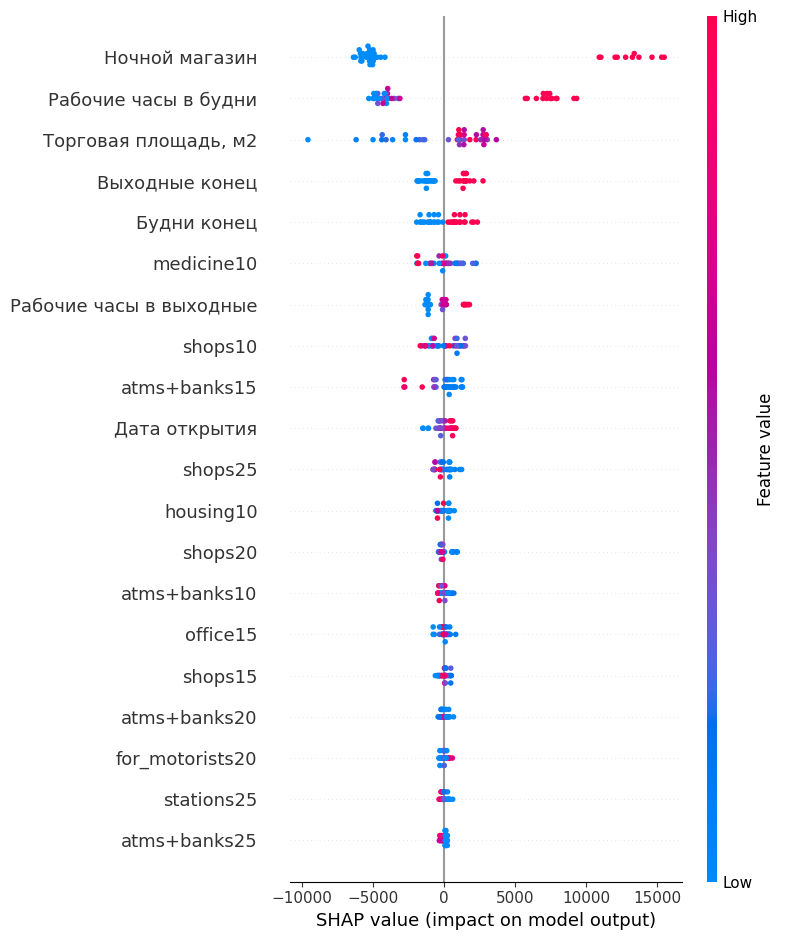

In [222]:
X_train, y_train = scaled_data[:num_in_train], revenue[:num_in_train]
X_test, y_test = scaled_data[num_in_train:], revenue[num_in_train:]
revenue_test = revenue[num_in_train:]

model = RandomForestRegressor( n_estimators = 50,
                               min_samples_split = 10,
                               min_samples_leaf = 4,
                               max_features = 'auto',
                               max_depth = 6,
                               bootstrap = True)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
print('RandomForestRegressor revenue MAPE: %.3f' % metrics.mean_absolute_percentage_error(y_test, y_pred_test))
revenue_pred = y_pred_test

explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

shap.summary_plot(shap_values)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


RandomForestRegressor avg_check MAPE: 0.097


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


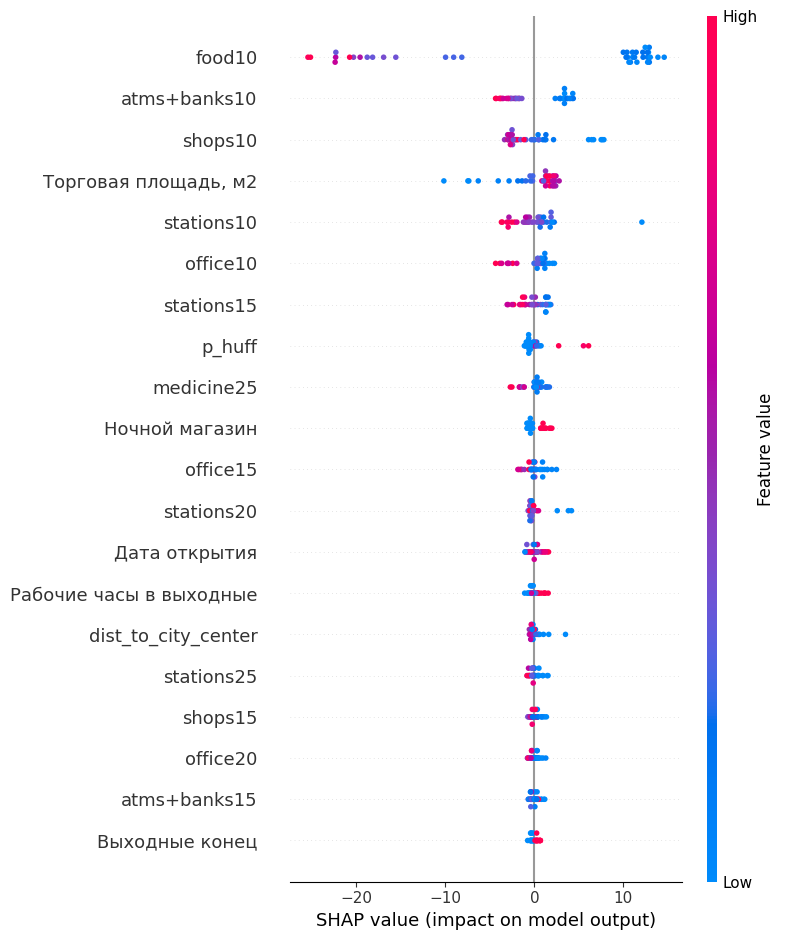

In [223]:
X_train, y_train = scaled_data[:num_in_train], avg_check[:num_in_train]
X_test, y_test = scaled_data[num_in_train:], avg_check[num_in_train:]
avg_check_test = avg_check[num_in_train:]

model = RandomForestRegressor( n_estimators = 50,
                               min_samples_split = 10,
                               min_samples_leaf = 4,
                               max_features = 'auto',
                               max_depth = 6,
                               bootstrap = True)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
print('RandomForestRegressor avg_check MAPE: %.3f' % metrics.mean_absolute_percentage_error(y_test, y_pred_test))
avg_check_pred = y_pred_test

explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

shap.summary_plot(shap_values)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


RandomForestRegressor num_checks MAPE: 0.199


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


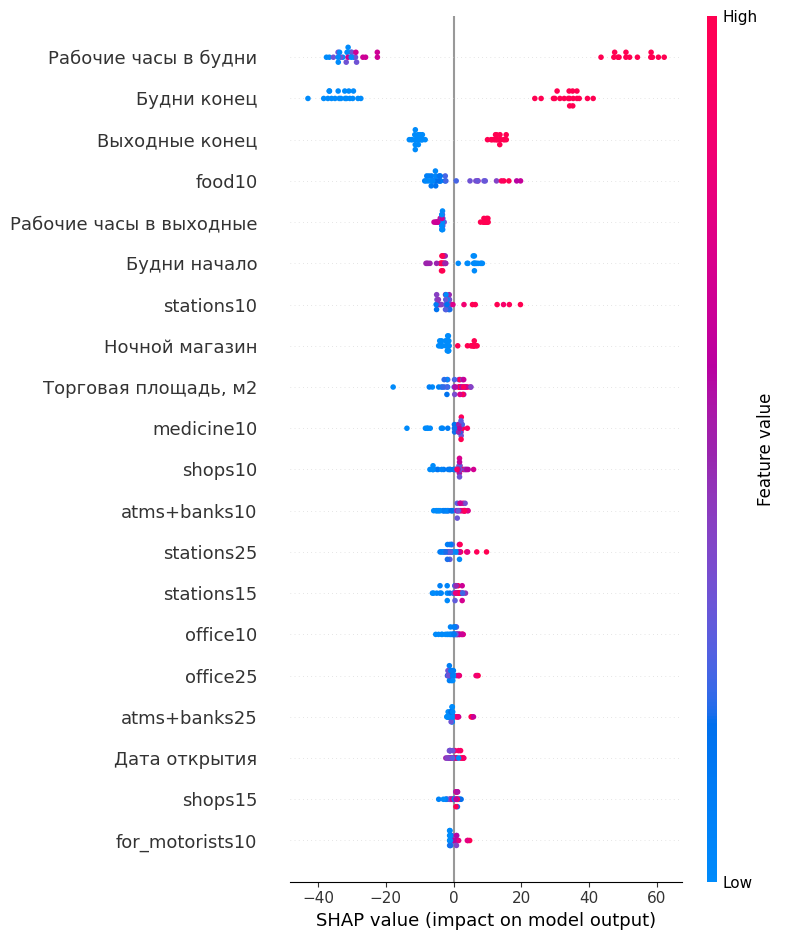

In [224]:
X_train, y_train = scaled_data[:num_in_train], num_checks[:num_in_train]
X_test, y_test = scaled_data[num_in_train:], num_checks[num_in_train:]
num_checks_test = num_checks[num_in_train:]

model = RandomForestRegressor( n_estimators = 50,
                               min_samples_split = 10,
                               min_samples_leaf = 4,
                               max_features = 'auto',
                               max_depth = 6,
                               bootstrap = True)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
print('RandomForestRegressor num_checks MAPE: %.3f' % metrics.mean_absolute_percentage_error(y_test, y_pred_test))
num_checks_pred = y_pred_test

explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

shap.summary_plot(shap_values)

In [225]:
def make_classes_for_num_checks(q):
  df_target['interval'] = pd.qcut(df_target["Чеки шт/мес"], q=q)
  df_target['makr_class'] = pd.qcut(df_target["Чеки шт/мес"], q=q, labels=False)

  for i in range(q):
    df_target.loc[df_target['makr_class'] == i, 'mean'] = df_target[df_target['makr_class'] == i]["Чеки шт/мес"].mean()

In [226]:
# def make_classes_for_num_checks(q):
#   df_target['interval'] = pd.cut(df_target["Чеки шт/мес"], bins=q)
#   df_target['makr_class'] = pd.cut(df_target["Чеки шт/мес"], bins=q, labels=False)

#   for i in range(q):
#     df_target.loc[df_target['makr_class'] == i, 'mean'] = df_target[df_target['makr_class'] == i]["Чеки шт/мес"].mean()

In [227]:
make_classes_for_num_checks(12)

num_checks_class = df_target["makr_class"].values

classes_dict = {}
for mark_class, mean in zip(df_target["makr_class"], df_target["mean"]):
  classes_dict[mark_class] = mean

In [228]:
X_train, y_train = scaled_data[:num_in_train], num_checks_class[:num_in_train]
X_test, y_test = scaled_data[num_in_train:], num_checks_class[num_in_train:]
num_checks_class_test = num_checks_class[num_in_train:]

classifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', random_state = 1)
classifier.fit(X_train, y_train)

y_pred_test = classifier.predict(X_test)
print('RandomForestRegressor num_checks accuracy_score: %.3f' % metrics.accuracy_score(y_test, y_pred_test))
num_checks_class_pred = y_pred_test


result_class_classification = []
for i in y_pred_test:
  result_class_classification.append(classes_dict[i])

RandomForestRegressor num_checks accuracy_score: 0.184


In [229]:
metrics.mean_absolute_percentage_error(num_checks_test, (result_class_classification+num_checks_pred)/2)

0.20594141637505362

In [230]:
metrics.mean_absolute_percentage_error(revenue_test, (avg_check_pred*((result_class_classification+num_checks_pred)/2)+revenue_pred)/2)

0.18994426486472551

In [231]:
metrics.mean_absolute_percentage_error(num_checks_test, result_class_classification)

0.24144740806037418

In [232]:
metrics.mean_absolute_percentage_error(revenue_test, avg_check_pred*result_class_classification)

0.24735617033189455

In [233]:
metrics.mean_absolute_percentage_error(revenue_test, (avg_check_pred*result_class_classification+revenue_pred)/2)

0.20060656504562172

In [234]:
metrics.mean_absolute_percentage_error(revenue_test, revenue_pred)

0.18300755158028367

In [235]:
metrics.mean_absolute_percentage_error(avg_check_test, avg_check_pred)

0.09741289867050813

In [236]:
metrics.mean_absolute_percentage_error(num_checks_test, num_checks_pred)

0.1990872035226441

In [237]:
metrics.mean_absolute_percentage_error(revenue_test, avg_check_pred*num_checks_pred)

0.20504084799227346

In [238]:
metrics.mean_absolute_percentage_error(revenue_test, (avg_check_pred*num_checks_pred+revenue_pred)/2)

0.19132273900501592

In [239]:
revenue_pred

array([ 52753.59272918,  57359.13299846,  58183.92997018,  60717.33078918,
        60178.77912846,  56922.96714615,  76946.39499604,  50137.07514403,
        53846.12955462,  58002.51880101,  94800.63074822,  46018.60562404,
        57017.54865739,  76871.51656444,  45209.37870944,  55402.09329113,
        44930.31003624,  55834.97217394,  76946.39499604,  57841.87057146,
        64984.41646128,  53385.44824449,  50328.44718062,  53793.2713184 ,
       100536.94443563,  81108.22411043,  45949.29199374,  75250.48020543,
        38462.77567119,  69239.36658186,  57859.59707848,  91781.85606383,
        59625.52941091,  56668.93210258,  73877.46513963,  88326.66181958,
        86791.76031824,  91921.46965178])

In [187]:
avg_check_pred*num_checks_pred

array([ 51122.34257209,  54958.6877935 ,  69946.11563249,  67483.63644714,
        52948.50333783,  58113.03407049,  77024.55510494,  49527.8233575 ,
        52358.44824347,  63884.57801953,  90567.75212545,  47764.63396315,
        60368.08675476,  71898.79682513,  49600.75805508,  51551.8176827 ,
        42271.64871595,  53367.86665132,  85071.10604476,  55779.53795985,
        68650.65048887,  52270.36543388,  46567.44404615,  53922.14769665,
       106669.05286358,  77078.73091122,  42086.48654455,  52784.71669793,
        40036.64083706,  85181.38849763,  47592.5636033 ,  76401.44868862,
        60363.27827324,  54336.21075439,  85800.37341546,  83447.71919103,
        90450.41840015, 105238.03449004])

In [ ]:
avg_check_pred*result_class_classification

array([ 84620.83194836,  57224.24977205,  43433.49357971,  62955.6644103 ,
        43036.43098559,  56339.69140244,  79546.23655474,  42494.83394374,
        32554.38884957,  62146.42305099, 111710.83536439,  35098.71416656,
        59786.27975609,  78689.30701829,  55264.73088126,  55158.74600861,
        39847.12141389,  36887.55800124,  81470.50156178,  40353.29035687,
        49070.25259388,  55098.1662941 ,  39474.56192732,  52133.01614751,
       114464.56968059,  91001.42269318,  46813.67056069,  62811.2617369 ,
        33832.96899416,  77584.8656297 ,  48180.23180907,  63758.29090334,
        88903.02454007,  33176.71083829,  77194.37480611,  91960.71825675,
       100416.03919337,  83637.58608318])

In [ ]:
revenue_test

array([ 55197.22222222,  46388.56444444,  54105.52444444,  57758.35111111,
        80328.28444444,  80114.89777778,  84327.68888889,  34175.00666667,
        37466.08444444,  76362.64888889,  99573.95555556,  33862.67333333,
        60999.85777778,  94985.76      ,  64385.49777778,  82205.27111111,
        35058.87555556,  44286.04888889,  79262.08888889,  67454.91555556,
        58642.06666667,  45329.01333333,  40460.50222222,  40866.29777778,
       160010.93333333, 117952.54222222,  53113.12888889,  78037.89333333,
        38146.28444444,  69664.37777778,  63505.75555556,  97071.75111111,
        71510.99555556,  73140.66666667, 100116.65777778,  79737.64444444,
        85149.15555556, 106199.43111111])